In [3]:
import random
import matplotlib.pyplot as plt
import rasterio
import os
from pathlib import Path
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam 

In [4]:
#source and label file path
data = Path("./data").resolve()
source = Path("./data/umd_mali_crop_type_source").resolve()
label = Path("./data/umd_mali_crop_type_labels").resolve()

In [5]:
if not os.path.isdir(f"{data}/rgb_source/"):
    os.makedirs(f"{data}/rgb_source/")

In [271]:
import numpy as np
# Load in field and mask
for i in range(0,len(next(os.walk(source))[1])):
        source_items= [
            f"{source}/{next(os.walk(source))[1][i]}/B01.tif",
             f"{source}/{next(os.walk(source))[1][i]}/B03.tif",
             f"{source}/{next(os.walk(source))[1][i]}/B02.tif",
        ]
        all_bands = np.zeros((len(source_items), 256, 256), dtype=np.uint8) #three bands
        profile = None
        for j, item in enumerate(source_items):
            with rasterio.open(item) as dataset:
                bands = dataset.read()
                all_bands[j] = bands[0] #placing the three bands in one image
                profile = dataset.profile
        profile.update(count=len(source_items))

        with rasterio.open(f"{data}/rgb_source/" +next(os.walk(source))[1][i]+'.tif', 'w+', **profile) as dst:
            dst.write(all_bands)
    #field = np.asarray(Image.open(f"{source}/{NAME}/B04.tif"))

In [6]:
src_files=next(os.walk(source))[1]
label_loc=next(os.walk(label))[1]
label_loc.remove('_common')

umd_mali_crop_type_source_15_2019_07_05   umd_mali_crop_type_labels_15


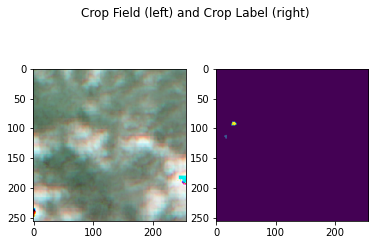

In [13]:
#NAME=os.listdir(label)[random.randint(0,33)]
src_files=next(os.walk(source))[1]
num=label_loc[random.randint(0,len(label_loc)-1)].split('_')[5]
NAME =f"umd_mali_crop_type_labels_{num}"
field = np.asarray(Image.open(f"{label}/{NAME}/labels.tif"))
src_list=[]
for item in src_files:
    if item.startswith(f"umd_mali_crop_type_source_{num}"):
        src_list.append(item)
ran=random.randint(0,len(src_list)-1)
source_img=np.asarray(Image.open(f"{data}/rgb_source/{src_list[ran]}.tif"))
print(src_list[ran]," ", NAME)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Crop Field (left) and Crop Label (right)')
ax1.imshow(source_img*2)
ax2.imshow(field)

In [9]:
src_files=next(os.walk(source))[1]
label_loc=next(os.walk(label))[1]
label_loc.remove('_common')
X= np.zeros((len(src_files), 256, 256,3), dtype=np.uint8)
Y= np.zeros((len(src_files), 256, 256), dtype=np.uint8)
j=0
for item in label_loc:
    num=item.split('_')[5]
    field = np.asarray(Image.open(f"{label}/{item}/labels.tif"))
    for src in src_files:
        if src[:-11]==f"umd_mali_crop_type_source_{num}":
#         if src.startswith(f"umd_mali_crop_type_source_{num}"):
            source_img=np.asarray(Image.open(f"{data}/rgb_source/{src}.tif"))
            X[j]=source_img
            Y[j]=field
            j=j+1

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(1082, 256, 256, 3)
(1082, 256, 256)
(136, 256, 256, 3)
(136, 256, 256)
(135, 256, 256, 3)
(135, 256, 256)


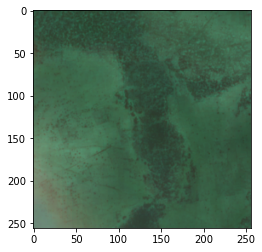

In [12]:
plt.imshow(x_train[200]*2)

In [14]:
def conv_block(inputs=None, n_filters=4, dropout_prob=0, max_pooling=True):
    #code reference: https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [7]:
# tf.config.run_functions_eagerly(False)
# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name="gpu")

In [59]:
def unet_model(input_size=(256, 256, 3), n_filters=4, n_classes=5):
    #code reference: https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc
    inputs = Input(input_size)
    #inputs = BatchNormalization()(inputs) # we can learn the normalization step
    #inputs = Dropout(0.5)(inputs)    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)  
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    #conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [60]:
img_height = 256
img_width = 256
num_channels = 3 #modify since we have 3 channels (rgb)

unet = unet_model((img_height, img_width, num_channels))

In [9]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 4)  112         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 4)  148         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 4)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
#save the model based on best validation loss
model_checkpoint = ModelCheckpoint(str(data)+'/unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
#stop training if no improvements after 50 epochs
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50)

In [9]:
#setting up and compiling the model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.003, name="Adam"
)
loss= loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# unet.compile(optimizer=optimizer, loss= loss,\
#                   metrics = ['accuracy'])

In [10]:
batch_size=8
#with tf.device("/cpu:0"):
history = loaded_model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              steps_per_epoch = len(x_train)//batch_size,
              validation_steps = len(x_val)//batch_size,
              batch_size=batch_size, epochs=500, callbacks=[model_checkpoint, model_earlyStopping])

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-05-04 15:19:32.507995: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-04 15:19:32.510072: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


135/135 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9976WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x168c8fca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
135/135 [==============================] - 21s 149ms/step - loss: 0.0188 - accuracy: 0.9976 - val_loss: 0.0180 - val_accuracy: 0.9977

E

135/135 [==============================] - 19s 143ms/step - loss: 0.0204 - accuracy: 0.9975 - val_loss: 0.0194 - val_accuracy: 0.9977

Epoch 00037: val_loss did not improve from 0.01801
Epoch 38/500
135/135 [==============================] - 19s 141ms/step - loss: 0.0194 - accuracy: 0.9977 - val_loss: 0.0194 - val_accuracy: 0.9977

Epoch 00038: val_loss did not improve from 0.01801
Epoch 39/500
135/135 [==============================] - 19s 143ms/step - loss: 0.0199 - accuracy: 0.9976 - val_loss: 0.0194 - val_accuracy: 0.9977

Epoch 00039: val_loss did not improve from 0.01801
Epoch 40/500
135/135 [==============================] - 19s 141ms/step - loss: 0.0197 - accuracy: 0.9976 - val_loss: 0.0193 - val_accuracy: 0.9977

Epoch 00040: val_loss did not improve from 0.01801
Epoch 41/500
135/135 [==============================] - 19s 140ms/step - loss: 0.0200 - accuracy: 0.9976 - val_loss: 0.0193 - val_accuracy: 0.9977

Epoch 00041: val_loss did not improve from 0.01801
Epoch 42/500
135/1

In [16]:
loaded_model = tf.keras.models.load_model(str(data)+'/unet_model.hdf5')

1/1 [==============================] - 0s 20ms/step - loss: 0.0165 - accuracy: 0.9981
[0.016451511532068253, 0.9980926513671875]
10


Text(0.5, 1.0, 'predicted label')

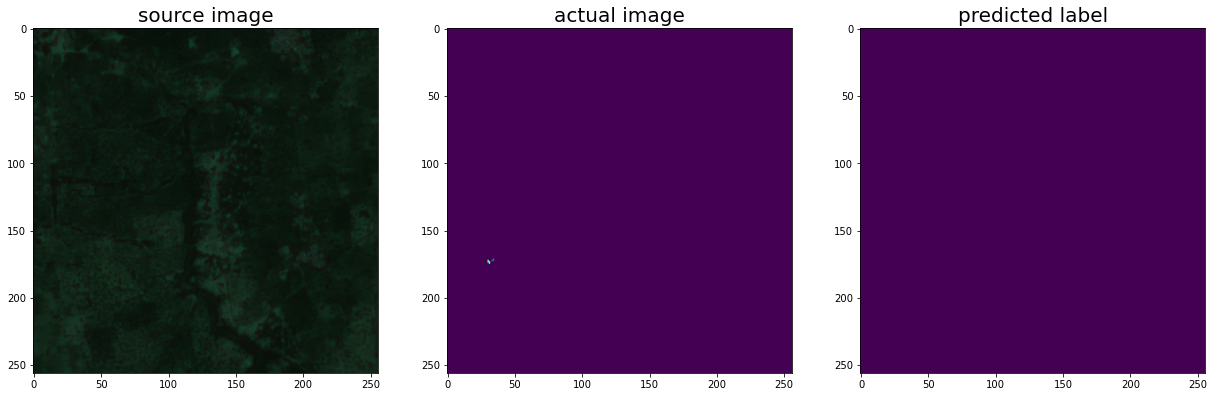

In [23]:
import random
i=random.randint(0, len(x_test)-1)
test_result= loaded_model.evaluate(np.expand_dims(x_test[i], 0),np.expand_dims(y_test[i], 0))
pred_mask = loaded_model.predict(np.expand_dims(x_test[i], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]
print(test_result) #print results on the random field
print (i) #print ID
# Perform a sanity check on some random training samples
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,10.80))
#fig.suptitle('Horizontally stacked subplots')
ax1.imshow(x_test[i])
ax1.set_title("source image", fontsize=20)
ax2.imshow(y_train[i])
ax2.set_title("actual image", fontsize=20)
ax3.imshow(pred_mask)
ax3.set_title("predicted label", fontsize=20)